>For this project, we will be working with the __Chest X-Ray Images (Pneumonia)__ dataset, from Kaggle [https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The objective of the project is to build a deep neural network model that can classify whether a given patient has pneumonia, given a chest x-ray image.

        Acknowledgements
        Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

        License: CC BY 4.0

        Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


## 2-Explore and Model



In [0]:
# importing necessary libraries.
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline
import time
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)

__Data Counts and Shapes__

__Standardize__ image data by dividing each matrix of rgb values by 255.

In [0]:
# instantiating rescaling generators tor train and val data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

__Reshape__ image data and labels

In [0]:
# generating training and validation data
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir, 
        shuffle=True, 
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


__Visualize Training Data Counts__

In [0]:
def bar_plot(dir):
    x_dir = os.listdir(dir+'/NORMAL')
    y_dir = os.listdir(dir+'/PNEUMONIA')
    x=len(x_dir)
    y=len(y_dir)
    if dir != test_dir: 
        # account for non - image files in `train` and `val` directories
        x = x - 1
        y = y - 1
    print(f'{dir} Images:\n')
    print('NORMAL:', x)
    print('PNEUMONIA:', y)
    print('Total images:', x + y)
    print('-'*50)
    # instantiate directory name for plot title
    subdir_title = str.split(dir, '/')[-2] + ' directory'
    category = ['NORMAL', 'PNEUMONIA']
    count = [x, y]
    plot = plt.bar(category,count) 
    plot[0].set_color('orange')
    plt.title(
        f"Number of values per category in {subdir_title.title()}\n")
    plt.show()

/root/data/chest_xray/chest_xray/train/ Images:

NORMAL: 1341
PNEUMONIA: 3875
Total images: 5216
--------------------------------------------------


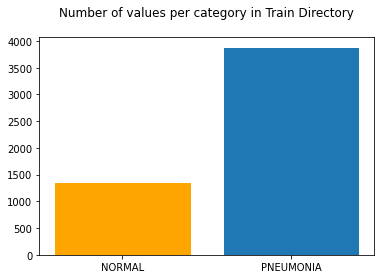

In [0]:
# plotting training data counts
bar_plot(train_dir)

> Training data is noticeably unbalanced.

/root/data/chest_xray/chest_xray/val/ Images:

NORMAL: 8
PNEUMONIA: 8
Total images: 16
--------------------------------------------------


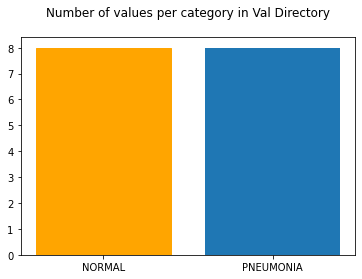

In [0]:
# plotting validation data counts
bar_plot(val_dir)

/root/data/chest_xray/chest_xray/test/ Images:

NORMAL: 234
PNEUMONIA: 390
Total images: 624
--------------------------------------------------


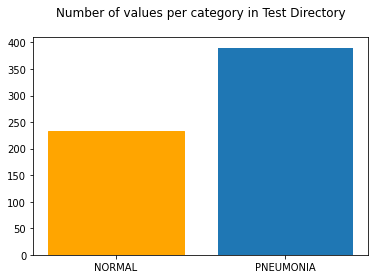

In [0]:
# plotting test data counts
bar_plot(test_dir)

> Test data is unbalanced, in the same direction as training data, though not as severely.

### Preview Images

In [0]:
# instantiate variables for a training image from each class
normal_example = os.listdir(f'{train_dir}/NORMAL')[33]
pneumonia_example = os.listdir(f'{train_dir}/PNEUMONIA')[33]

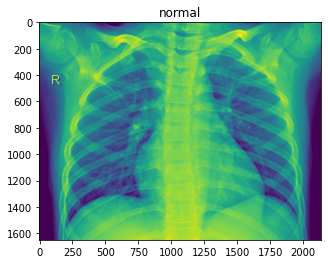

In [0]:
# plot a normal class training image
normal_img = plt.imread(f'{train_dir}/NORMAL/{normal_example}')
plt.title("normal")
plt.imshow(normal_img)
plt.show()

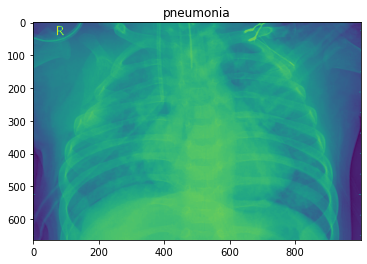

In [0]:
# plot a pneumonia class training image
pneumonia_img = plt.imread(f'{train_dir}/PNEUMONIA/{pneumonia_example}')
plt.imshow(pneumonia_img)
plt.title('pneumonia')
plt.show()

## Design Model 1
>Using Keras:
* Design a simple convolutional neural network (cnn)
* We will 'flatten' to a send a single dimension array to the single - node output layer 
* Compile this model

In [0]:
# importing necessary libraries
# from keras import layers
# from keras import models
# from keras import optimizers

In [0]:
# building the CNN model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# compiling the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
# importing keras modules
# from keras.callbacks import EarlyStopping
# from keras.callbacks import ModelCheckpoint
# from keras.callbacks import ReduceLROnPlateau

In [0]:
# creating a directory for saving models
!mkdir ./models/

Create Checkpoints in the Model History

>Import keras modules: 
* to stop training when a monitored quantity has stopped improving
* to save the model after every epoch
* to reduce learning rate when a metric has stopped improving


In [0]:
# creating callback checkpoints
f_path = './models/'
my_callbacks = [
    # stopping if no improvement after 15 epochs
    EarlyStopping(patience=15, verbose=1),
    ## reducing learning rate if no improvement after 3 epochs
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.001, verbose=1),
    # saving the full model at each improvement
    ModelCheckpoint(filepath = f_path + 'p3_model.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [0]:
# training and evaluating the model
# using the callback in the `model.fit`
history = model.fit_generator(train_generator,  
                              # 32 steps for each of 163 epochs, for
                              # 5216 training samples
                              steps_per_epoch=64, 
                              epochs=82, 
                              validation_data=validation_generator, 
                              validation_steps=16, 
                              class_weight = 'auto',
                              callbacks = my_callbacks)

Epoch 1/82
64/64 [==============================] - 24s 374ms/step - loss: 0.5158 - acc: 0.7812 - val_loss: 0.6653 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 0.66534, saving model to ./models/p3_model.h5
Epoch 2/82
64/64 [==============================] - 18s 281ms/step - loss: 0.2854 - acc: 0.8867 - val_loss: 0.6437 - val_acc: 0.6875

Epoch 00002: val_loss improved from 0.66534 to 0.64368, saving model to ./models/p3_model.h5
Epoch 3/82
64/64 [==============================] - 17s 268ms/step - loss: 0.2031 - acc: 0.9155 - val_loss: 0.7755 - val_acc: 0.6250

Epoch 00003: val_loss did not improve from 0.64368
Epoch 4/82
64/64 [==============================] - 18s 287ms/step - loss: 0.1544 - acc: 0.9448 - val_loss: 0.3623 - val_acc: 0.8750

Epoch 00004: val_loss improved from 0.64368 to 0.36233, saving model to ./models/p3_model.h5
Epoch 5/82
64/64 [==============================] - 18s 275ms/step - loss: 0.1350 - acc: 0.9512 - val_loss: 0.8384 - val_acc: 0.6875

Epoc

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.43680480122566223
val acc: 0.8125


The reported validation scores should be ~~those of our best~~~ model weignts.

__Visualize Training Results__

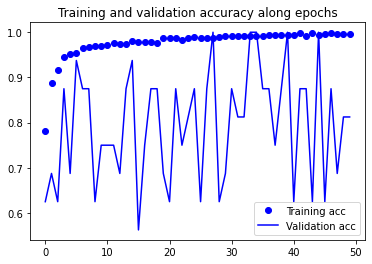

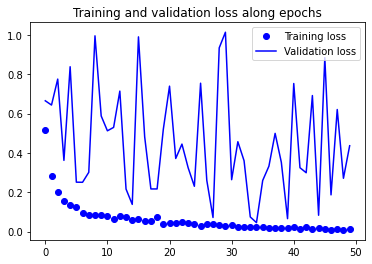

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy along epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss along epochs')
plt.legend()
plt.show()

> The jagged validation loss and accuracy suggest that our model has room for improvement. Options can include making adjustments to any on or several parameters, including verifying __shuffling__ of the training data, increasing the batch size or steps per batch to ensure reasonable sampling from each class during training, __longer training time__ (more epochs).

In [0]:
# download the model locally
files.download('./models/p3_model.h5')



> We'll reload the saved model.
* The best model was saved via callbacks to 'p3_model.h5'.
* We can evaluate it against our validation generator, to verify that the score reported above was based on our best model weights.



In [0]:
from keras.models import load_model
 
# loading model
model = load_model('./models/p3_model.h5')

# viewing a textual representation of the model's architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 331776)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                21233728  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,253,185
Trainable params: 21,253,185
Non-trainable params: 0
__________________________________________

Run the saved model on validation data to see if we approximate the validation scores reported above.

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.045831404626369476
val acc: 1.0


* Loss and accuracy scores are each higher, for the test set.
* We can evaluate the model on test data.

In [0]:
# running the test set in one batch
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=624, 
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=16)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.9870075583457947
test acc: 0.8028846383094788


> We see the following results from applying our model to the test set.
>
>|val loss: 0.045||test loss: 0.98|
>|----|----|----|
>|val acc: 1.0||test acc: 0.80|

>
>
* Compared to results from the validation set, loss is 53 points higher.
* Accuracy is 20 points lower, on the test set.

Let's check a __classification report__.

In [0]:
# instantiate variables for true and predicted arrays
y_true=test_generator.classes

y_pred = model.predict_generator(test_generator)
y_pred = np.rint(y_pred)

In [0]:
# from sklearn.metrics import confusion_matrix, classification_report
# viewing classification report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.37      0.19      0.25       234
           1       0.62      0.80      0.70       390

    accuracy                           0.57       624
   macro avg       0.49      0.50      0.48       624
weighted avg       0.53      0.57      0.53       624



> We see a good recall score for pneumonia images, which is a useful indicator.
* Recall indicates the ratio of positive predictions to the total number of actual positive samples, calculated as TP/(TP + FN).
* We can gain additional clarity from visualizing a confusion matrix plot for our model results.

[[ 45 189]
 [ 78 312]]


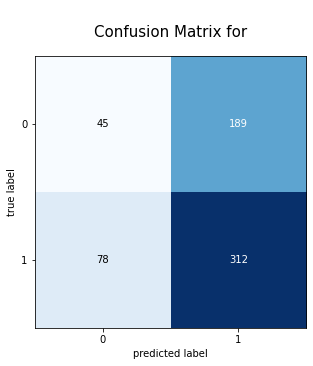

In [0]:
labels = [0,1]
CM = confusion_matrix(y_true, y_pred, labels)

fig, ax = plot_confusion_matrix(conf_mat=CM, 
                                figsize=(5, 5), 
                                hide_ticks=False, 
                                cmap=plt.cm.Blues)

ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
print(CM) 

plt.title("\nConfusion Matrix for model", 
          fontsize=15)
fig.savefig("model_1_CM", dpi=100)
plt.show()

In [0]:
# summing predictions
print("Predicted 'NORMAL': ", sum(1 for i in y_pred if i == 0))
print("Predicted 'PNEUMONIA':", sum(1 for i in y_pred if i == 1))

Predicted 'NORMAL':  123
Predicted 'PNEUMONIA': 501


> `See analysis, below.`

In [0]:
# categorizing results
def perf_measure(y_true, y_pred):
    """
    Takes 'actual' and 'predicted' labels and returns the number of
    true negative, true positive, false negative, and false positive
    predictions
    """
    TN = CM[0][0]
    TP = CM[1][1]
    FN = CM[1][0]
    FP = CM[0][1]

#    print(f"TN = {TN}\nTP = {TP}\nFN = {FN}\nFP = {FP}\n")

    return None

In [0]:
#viewing performance measures
perf_measure(y_true, y_pred)

TN = 45
TP = 312
FN = 78
FP = 189



This report encouraging, though not ideal:
>* __T__rue __N__egatives (pred 0, true 0): the number of patients correctly predicted to not to have pneumonia: 45
* __T__rue __P__ositives (pred 1, true 1): the number of patients correctly predicted to have pneumonia: 312
* __F__alse __N__egatives (pred 0, true 1): the number of patients falsely predicted to not to have pneumonia: __78__
* __F__alse __P__ositives (pred 1, true 0): the number of patients falsely predicted to have pneumonia: __189__

False positives would be preferred over false negatives, in this type of case.
>* Where false positives could unnecessarily result in additional testing, false negatives could result in failure to treat patients that require treatment.
* Our false positive results far outweigh false negative results
* Now, our target is a model that achieves lower error, overall.

### * Tuning Hyperperameters


__Data Generation__
> There are a number of approaches we can take to make our data more 'generalizeable', so that we optimize its ability to perfom well with new, unseen data.

Let's run a few things up the flagpole.

In [0]:
# instantiating a datagen to slightly transform images within
# specified ranges
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   width_shift_range=0.15, 
                                   height_shift_range=0.2, 
                                   shear_range=0.15, 
                                   zoom_range=0.2, 
                                   horizontal_flip=False, #
                                   fill_mode='nearest')

# generating transformed training data on - the - fly
# transformations may slow the fit process
train_generator = train_datagen.flow_from_directory(
        # using the same hyperparameters as the first model
        train_dir, 
        shuffle=True, 
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=652,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# we don't need to make adjustments to the final test set, but we can
# use a datagen to scale validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# transforming only image size, for validation data
validation_generator = test_datagen.flow_from_directory(val_dir, 
                                    target_size=(150, 150), 
                                    batch_size=8,  # half the sample
                                    class_mode='binary')



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Augmented `model_b`

In [0]:
## # build on the first model to create `model_b`
input_shape = (150, 150, 3)
print(input_shape)

model_b = models.Sequential()
model_b.add(layers.Conv2D(32, (2, 2), activation='relu', 
                        input_shape=input_shape))
model_b.add(layers.MaxPooling2D((2, 2)))

model_b.add(layers.Conv2D(64, (3, 3), activation='relu'))
# adding a pooling layer
model_b.add(layers.MaxPooling2D((2, 2)))

# increasing model depth
model_b.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_b.add(layers.MaxPooling2D((2, 2)))

model_b.add(layers.Flatten())
model_b.add(layers.Dense(64, activation='relu'))
model_b.add(layers.Dense(1, activation='sigmoid'))

(150, 150, 3)


Compile `model_b`

In [0]:
# compiling the model
model_b.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc'])

# adding callback functions
f_path = './models/'

my_callbacks = [
    # stopping if no improvement after 20 epochs (+ 5)
    EarlyStopping(patience=20, verbose=1),
    ## reducing learning rate if no improvement after 3 epochs
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    # saving the full model at each improvement
    ModelCheckpoint(filepath = f_path + 'p3_model_a.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]


Fit `model_b`

In [0]:
# fitting a model to training set including transformations
history_b = model_b.fit_generator(train_generator,  
                              # 16 steps for each of 326 epochs, for
                              # 5216 training samples
                              steps_per_epoch=16,   # down from 32
                              epochs=326,           # up from 163
                              validation_data=validation_generator, 
                              validation_steps=16, 
                              class_weight = 'auto',
                              callbacks = my_callbacks)

Epoch 1/326
16/16 [==============================] - 132s 8s/step - loss: 48.5413 - acc: 0.6777 - val_loss: 0.6939 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.69385, saving model to ./models/p3_model_a.h5
Epoch 2/326
16/16 [==============================] - 129s 8s/step - loss: 0.5295 - acc: 0.7429 - val_loss: 0.6913 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.69385 to 0.69126, saving model to ./models/p3_model_a.h5
Epoch 3/326
16/16 [==============================] - 129s 8s/step - loss: 0.4348 - acc: 0.7429 - val_loss: 0.6907 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.69126 to 0.69074, saving model to ./models/p3_model_a.h5
Epoch 4/326
16/16 [==============================] - 130s 8s/step - loss: 0.3699 - acc: 0.7429 - val_loss: 0.6923 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.69074
Epoch 5/326
16/16 [==============================] - 130s 8s/step - loss: 0.3889 - acc: 0.8223 - val_loss: 0.6915 - val_acc: 0.8125

Ep

In [0]:
val_loss, val_acc = model_b.evaluate_generator(validation_generator)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.687382698059082
val acc: 0.5


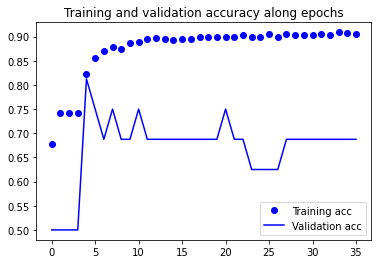

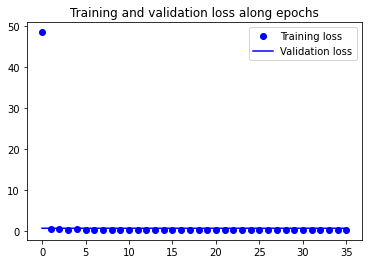

In [0]:
acc = history_b.history['acc']
val_acc = history_b.history['val_acc']
loss = history_b.history['loss']
val_loss = history_b.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy along epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss along epochs')
plt.legend()
plt.show()

### Evaluate model_b on Test Data

In [0]:
# using 39 batches of 16 steps for 624 test samples
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=39, 
                                                  class_mode='binary')

# using 39 steps to increase samples per batch
test_loss, test_acc = model_b.evaluate_generator(test_generator, steps=39)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.6861081123352051
test acc: 0.8389217853546143


> After viewing validation scores for the augmented model, I did not neccessarily expect to see improvement in test scores over our first model. But, here we are:
>
>|model test loss: 0.98||model_b test loss: 0.68|
>|----|----|----|
>|model test acc: 0.80||test acc: 0.84|

> `model_b` hit a plateau for accuracy at epoch 5 and validation loss did not improve after epoch 16.
* Conventional wisdom prepared me to accept that there is not a lot, if any, benefit to changing numerous hyperperameters all at once. The approach is likely to not work, training can be much more expensive, and any change in results are difficult to interpret.
* About half of our training time was wasted time
* Without performing a resource - heavy gridsearch, it may be best to adjust only one or two things to determine how the adjustments benefit or harm model performance.

Instead, we have achieved improvements in both loss and accuracy.
> It may still be valuable to return to the original model and try:
* changing only datagen transformations,
* making adjustments to the optimizer used

First, let's see how our performance measures have been affected.

In [0]:
# instantiate variables for true and predicted arrays
y_true=test_generator.classes

y_pred = model_b.predict_generator(test_generator)
y_pred = np.rint(y_pred)

[[ 61 173]
 [114 276]]


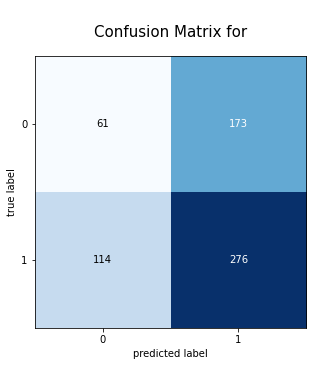

In [0]:
# plotting confusion matrix
labels = [0,1]
CM = confusion_matrix(y_true, y_pred, labels)

fig, ax = plot_confusion_matrix(conf_mat=CM, 
                                figsize=(5, 5), 
                                hide_ticks=False, 
                                cmap=plt.cm.Blues)

ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
print(CM) 

plt.title("\nConfusion Matrix for model_b", 
          fontsize=15)
fig.savefig("model_1_CM", dpi=100)
plt.show()

In [0]:
# summing predictions
print("Predicted 'NORMAL': ", sum(1 for i in y_pred if i == 0))
print("Predicted 'PNEUMONIA':", sum(1 for i in y_pred if i == 1))

Predicted 'NORMAL':  175
Predicted 'PNEUMONIA': 449


> `See analysis, below.`

In [0]:
#viewing performance measures
perf_measure(y_true, y_pred)

TN = 61
TP = 276
FN = 114
FP = 173



`model_b` actually has __more__ false negatives than the first model. In that regard, it is not an improvement. Ideally, we would see improvement in our recall score Recall = TP/(TP + FN)

## `model_c`


__Change One Thing__, only.

> So, let's go ahead and add only the transformations to the first model.

In [0]:
# instantiating a datagen to slightly transform images within
# specified ranges (including the original rescaling)
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.15, 
                                   height_shift_range=0.2, 
                                   shear_range=0.15, 
                                   zoom_range=0.2, 
                                   horizontal_flip=False, #
                                   fill_mode='nearest')

# re - instantiating our original training and validation generators
# to include the new datagen transformations
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir, 
        shuffle=True, 
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)  # original rescaling

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
# building the transformed training data `model_c`
input_shape = (150, 150, 3)

# using the original model architecture
model_c = models.Sequential()

model_c.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape))
model_c.add(layers.MaxPooling2D((2, 2)))

model_c.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_c.add(layers.Flatten())
model_c.add(layers.Dense(64, activation='relu'))
model_c.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# compiling the model
model_c.compile(loss='binary_crossentropy', 
                # we can increase the learning rate and let it reduce
                # via the ReduceLROnPlateau callback function
              optimizer=optimizers.RMSprop(lr=1e-3),
              metrics=['acc'])

In [0]:
# creating callback checkpoints
f_path = './models/'
my_callbacks = [
    # stopping if no improvement after 15 epochs
    EarlyStopping(patience=15, verbose=1),
    # reducing learning rate if no improvement after 3 epochs
    # correcting the min_lr, to ensure it is lower than the start
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    # saving the full model at each improvement
    ModelCheckpoint(filepath = f_path + 'p3_model_c.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [0]:
# training and evaluating the model with transformations
history_c = model_c.fit_generator(train_generator,  
                              # 32 steps for each of 163 epochs, for
                              # 5216 training samples
                              steps_per_epoch=32, 
                              epochs=163, 
                              validation_data=validation_generator, 
                              validation_steps=16, 
                              class_weight = 'auto',
                              callbacks = my_callbacks)

Epoch 1/163
32/32 [==============================] - 16s 496ms/step - loss: 1.5514 - acc: 0.6680 - val_loss: 0.7743 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.77429, saving model to ./models/p3_model_c.h5
Epoch 2/163
32/32 [==============================] - 13s 408ms/step - loss: 0.7302 - acc: 0.7080 - val_loss: 0.9398 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.77429
Epoch 3/163
32/32 [==============================] - 13s 417ms/step - loss: 0.5410 - acc: 0.7334 - val_loss: 1.2628 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.77429
Epoch 4/163
32/32 [==============================] - 13s 401ms/step - loss: 0.5189 - acc: 0.7471 - val_loss: 0.9128 - val_acc: 0.5625

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_loss did not improve from 0.77429
Epoch 5/163
32/32 [==============================] - 13s 401ms/step - loss: 0.3531 - acc: 0.8379 - val_loss: 0.8446 - val_acc: 0.6250


> That was a much quicker model. How did it perform?

In [0]:
# downloading the model locally
files.download('./models/p3_model_c.h5')



> We'll reload the saved model.
* The best model was saved via callbacks to 'p3_model.h5'.
* We can evaluate it against our validation generator, to verify that the score reported above was based on our best model weights.



In [0]:
# reloading saved model and best weights
from keras.models import load_model
 
# loading model
model = load_model('./models/p3_model_c.h5')

# viewing model architecture
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
flatten_26 (Flatten)         (None, 331776)            0         
_________________________________________________________________
dense_47 (Dense)             (None, 64)                21233728  
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 65        
Total params: 21,253,185
Trainable params: 21,253,185
Non-trainable params: 0
_________________________________________

In [0]:
val_loss, val_acc = model_c.evaluate_generator(validation_generator)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.7782552242279053
val acc: 0.625


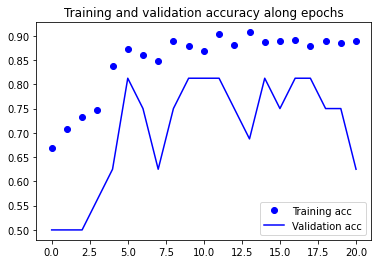

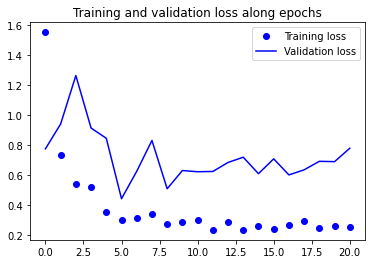

In [0]:
acc = history_c.history['acc']
val_acc = history_c.history['val_acc']
loss = history_c.history['loss']
val_loss = history_c.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy along epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss along epochs')
plt.legend()
plt.show()

While there appears to be a general tendency, between training data and predictions for validation data, the validation batch size (only 16 total samples) may prevent the convergence we would like to see in our validation accuracy and loss plots.

### Evaluate model_c on Test Data

In [0]:
# using 39 batches of 16 steps for 624 test samples
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=39, 
                                                  class_mode='binary')

# using 39 steps to increase samples per batch
test_loss, test_acc = model_c.evaluate_generator(test_generator, steps=39)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.474753737449646
test acc: 0.8093359470367432


> We can compare our latest results to `model_b`, even though we consider that model to have unfavorable type - error ratios:
>
>|model_b test loss: 0.68||model_c test loss: 0.47|
>|----|----|----|
>|model_b test acc: 0.84||model_c test acc: 0.81|

> Again, we have achieved improvements in both loss and accuracy.
* Let's check performance metrics.

In [0]:
# instantiate variables for true and predicted arrays
y_true=test_generator.classes

y_pred = model_c.predict_generator(test_generator)
y_pred = np.rint(y_pred)

[[ 68 166]
 [108 282]]


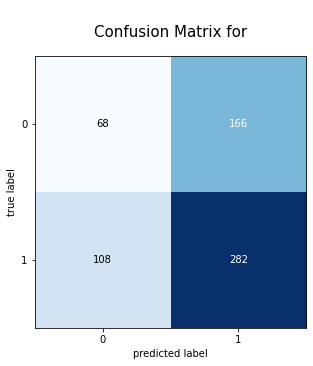

In [0]:
# plotting confusion matrix
labels = [0,1]
CM = confusion_matrix(y_true, y_pred, labels)

fig, ax = plot_confusion_matrix(conf_mat=CM, 
                                figsize=(5, 5), 
                                hide_ticks=False, 
                                cmap=plt.cm.Blues)

ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
print(CM) 

plt.title("\nConfusion Matrix for", 
          fontsize=15)
fig.savefig("model_1_CM", dpi=100)
plt.show()

These metrics appear to not be too far off from `model_b`

In [0]:
# summing predictions
print("Predicted 'NORMAL': ", sum(1 for i in y_pred if i == 0))
print("Predicted 'PNEUMONIA':", sum(1 for i in y_pred if i == 1))

Predicted 'NORMAL':  176
Predicted 'PNEUMONIA': 448


In [0]:
#viewing performance measures
perf_measure(y_true, y_pred)

perf. accuracy =    56.0897
perf. recall =      72.3077
perf. precision =   62.9464
perf. f1 =          67.3031


`model_b` actually has __more__ false negatives than the first model. In that regard, it is not an improvement. Ideally, we would see improvement in our recall score Recall = TP/(TP + FN)

# Working with a Completed Model (example)

> We have more work to do with this set, but le's see what it would look like to work with a completed model.
* We will look at a model applied to the same dataset.
* This model uses an RMSprop optimizer.

In [0]:
# evaluating the best model on test data
# setting steps to 39 and batch_size to 16 (for 624 images)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=16, 
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=39)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.5838384628295898
test acc: 0.8253205418586731


* This model also may be used as a basis for further tuning or distributed as - is.

## Distribution

* Since we previously saved our `my_model.h5` model, we can distribute it and use it on another system or for another project.
* A string summary of the mode's architecture may be saved and shared, as well.

In [0]:
# loading the saved model
from keras.models import load_model

filepath = '/root/data/models/p3_model.h5' # current path to saved file

dist_model = load_model(filepath, 
         custom_objects={'loss':'binary_crossentropy'})

# printing string summary
dist_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In addition, t model's architecture may be shared as an image.

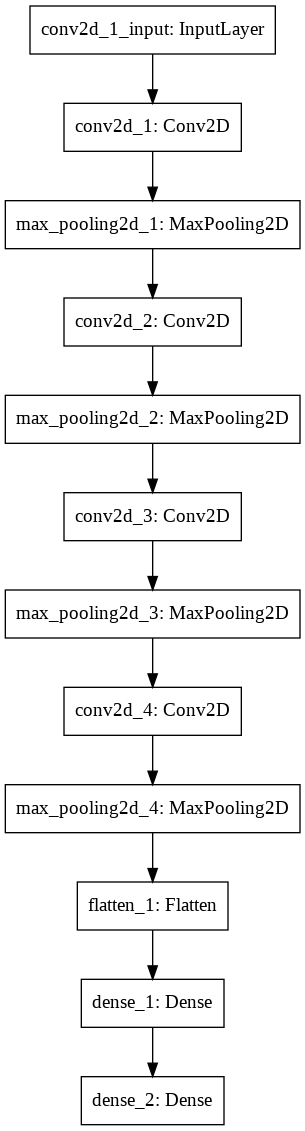

In [0]:
from keras.utils import plot_model

# plot model architecture, only
plot_model(dist_model)

# Summary / Future Work
We created a few supervised learning models, to look at how we might predict whether or not a patient has pneumonia, based on x-ray images of patient lungs.
> This project takes into consideration the particular requirements of performing data science modeling for a non - trivial task.
* A model with too many incorrect predictions (errors) could result in failure to properly diagnose and treat patient illness.
* Given prediction errors, it would be preferable to predict more false positives than false negatives--incorrectly identifying disease, which may lead to additional tests, rather than incorrectly determining that there is no disease, which may lead to a lack of necessary treatment.

A tool that may be useful for additional work on this project is the precision-recall curve.
![image.png](https://github.com/jammy-bot/pneumonia-x-ray-deep-learning-classification/blob/master/images/pre-rec-example-1.png | via https://acutecaretesting.org/)*Example of precision-recal curve plot*

The precision-recall plot provides at - a - glance visualization of model performance, particularly relevant to this type of problem, where you first and foremost want to ensure that the model identifies the vast majority of persons with the disease as having the disease. Usefully, this plot is less sensitive to training imbalance than an ROC.

To further tune our model, we can make adjustments to the many available hyperparameters:
* differnt transformations in __data augmentation__
* increase, decrease, or __alter layers__ and __model depth__
* use different __activations__
* add __dropout__ layers that only pass - on _some_ of the data to the next layer, to help prevent overfitting....
* Of course, there is also the gold standard: __more data__



# ===========================================

---



# Errata / previous work
\

> Loss is much better than the previous model, but accuracy has slightly fallen.
>
>|previous test loss: 1.14||current test loss: 0.70|
>|----|----|----|
>|previous test acc: 0.77||current test acc: 0.73|

In [0]:
# instantiate variables for true and predicted arrays
y_true=test_generator.classes

y_pred = model_c.predict_generator(test_generator)
y_pred = np.rint(y_pred)

In [0]:
# summing predictions
print("Predicted 'NORMAL': ", sum(1 for i in y_pred if i == 0))
print("Predicted 'PNEUMONIA':", sum(1 for i in y_pred if i == 1))

Predicted 'NORMAL':  624
Predicted 'PNEUMONIA': 0


In [0]:
# from sklearn.metrics import confusion_matrix, classification_report
# viewing classification report
# print(classification_report(y_true, y_pred, labels=[0,1]))

## Model 2

Let's try:
* more layers
* add dropout layers after each pooling layer

In [0]:
model_2 = models.Sequential()

model_2.add(layers.Conv2D(32, (2, 2), activation='relu',
                        input_shape=(150, 150, 3)))
model_2.add(layers.MaxPooling2D(pool_size=(3,3))), 

model_2.add(layers.Conv2D(64, (2,2), activation='relu')), 
model_2.add(layers.MaxPooling2D(pool_size=(3,3))), 

model_2.add(layers.Conv2D(128, (3,3), activation='relu')), 
model_2.add(layers.MaxPooling2D(pool_size=(2,2))),

model_2.add(layers.Conv2D(128, (2,2), activation='relu')), 
model_2.add(layers.MaxPooling2D(pool_size=(2,2))), 

model_2.add(layers.Flatten()), 
model_2.add(layers.Dropout(0.15)), 

model_2.add(layers.Dense(512, activation='relu')), 
model_2.add(layers.Dropout(0.15)), 

model_2.add(layers.Dense(256, activation='relu')), 
model_2.add(layers.Dense(1, activation='sigmoid'))

* Change the optimizer to `Adam`
* use 'accuracy' metrics

In [0]:
# compiling the model
model_2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

In [0]:
# creating callback checkpoints
my_callbacks = [
    EarlyStopping(patience=10, verbose=1), # lowered patience
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = f_path + 'p3_model_2.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

Trade `steps_per_epoch` and `epochs` values, to train longer per epoch.

In [0]:
# training and evaluating the model
# using the callback in the `model.fit`
history_2 = model_2.fit_generator(train_generator, 
                              shuffle=True, 
                              steps_per_epoch=39, 
                              epochs=16, 
                              validation_data=validation_generator, 
#                              validation_steps=50, 
#                              class_weight=class_weights,
                              callbacks = my_callbacks)

Epoch 1/16
39/39 [==============================] - 313s 8s/step - loss: 1.9527 - acc: 0.6451 - val_loss: 0.6925 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.69250, saving model to ./models/p3_model_2.h5
Epoch 2/16
39/39 [==============================] - 315s 8s/step - loss: 0.5016 - acc: 0.7770 - val_loss: 0.6912 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.69250 to 0.69115, saving model to ./models/p3_model_2.h5
Epoch 3/16
39/39 [==============================] - 316s 8s/step - loss: 0.3437 - acc: 0.8506 - val_loss: 0.6906 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.69115 to 0.69062, saving model to ./models/p3_model_2.h5
Epoch 4/16
39/39 [==============================] - 315s 8s/step - loss: 0.2847 - acc: 0.8780 - val_loss: 0.6987 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.69062
Epoch 5/16
39/39 [==============================] - 315s 8s/step - loss: 0.2593 - acc: 0.8900 - val_loss: 0.6851 - val_acc: 0.5000

Epoch 00

In [0]:
val_loss, val_acc = model_2.evaluate_generator(validation_generator, 
                                               steps=50)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.6920414566993713
val acc: 0.5


In [0]:
# download the model
files.download('./models/p3_model_2.h5')

In [0]:
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 149, 149, 32)      416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 48, 48, 64)        8256      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 6, 6, 128)        

__Visualize Training Results__

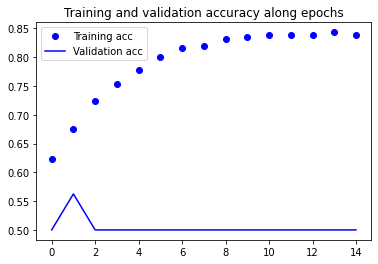

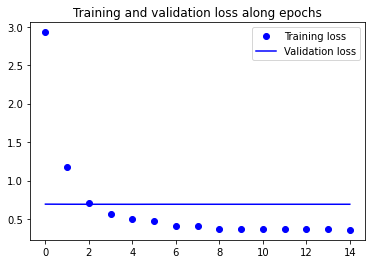

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy along epochs')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss along epochs')
plt.legend()
plt.show()

> Early stopping may have been a bit premature, for this model, as measures do not appear to have settled into a definitive trend.

### Evaluate Model 2 on Test Data

In [0]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model_2.evaluate_generator(test_generator, steps=50)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.6922323703765869
test acc: 0.6189024448394775


>The second model performed poorly.

__Plot Confusion Matrix__

In [0]:
# viewing classification report
# from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.35      0.26      0.30       234
           1       0.61      0.71      0.66       390

    accuracy                           0.54       624
   macro avg       0.48      0.48      0.48       624
weighted avg       0.51      0.54      0.52       624



In [0]:
# from sklearn.metrics import confusion_matrix
# instantiate variables for true and predicted arrays
y_true=test_generator.classes

y_pred = model_2.predict_generator(test_generator)
y_pred = np.rint(y_pred)

Call on the custom function to measure performance

In [0]:
#viewing performance measures
perf_measure(y_true, y_pred)

TN = 61
TP = 276
FN = 114
FP = 173



[[  0 234]
 [  0 390]]


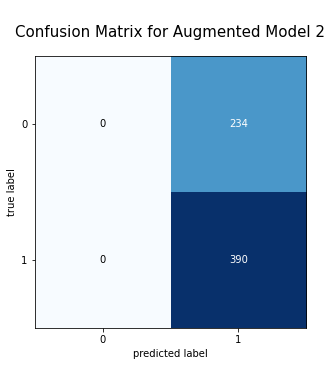

In [0]:
labels = [0,1]
CM = confusion_matrix(y_true, y_pred, labels)

fig, ax = plot_confusion_matrix(conf_mat=CM , 
                                figsize=(5, 5), 
                                hide_ticks=False, 
                                cmap=plt.cm.Blues)

ax.set_xticklabels([''] + labels) 
ax.set_yticklabels([''] + labels) 
print(CM) 

plt.title("\nConfusion Matrix for Augmented Model 2", 
          fontsize=15)
fig.savefig("aug_model_2_CM", dpi=100)
plt.show()

In [0]:
# from sklearn.metrics import confusion_matrix
y_true=test_generator.classes
print(y_true)

y_pred = model_2.predict_generator(test_generator)
y_pred = np.rint(y_pred)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

>It looks as though the training labels did not shuffle as expected.

## Model 3

* trying fewer layers and fewer dropouts
* add dropout layers after each pooling layer

In [0]:
# building the a 2nd CNN model
model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                        input_shape=(150, 150, 3)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(Dropout(0.25))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Flatten() )# this converts 3D feature maps to 1D vectors
model_3.add(layers.Dense(512, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

* Change the optimizer to `Adam`
* use 'accuracy' metrics

In [0]:
# compiling the model
model_3.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

>Import keras modules: 
* to stop training when a monitored quantity has stopped improving
* to save the model after every epoch
* to reduce learning rate when a metric has stopped improving


In [0]:
# importing keras modules
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [0]:
# increase early stopping patience

In [0]:
# updating callback checkpoints
f_path = './models/'
my_callbacks = [
    EarlyStopping(patience=7, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = f_path + 'p3_model_3.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [0]:
# training and evaluating the model
# using the callback in the `model.fit`
history_3 = model_3.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=validation_generator, 
                              validation_steps=50, 
                              callbacks = my_callbacks)

Epoch 1/30
100/100 [==============================] - 223s 2s/step - loss: 10.3657 - acc: 0.6851 - val_loss: 0.6920 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 0.69203, saving model to ./models/p3_model_3.h5
Epoch 2/30
100/100 [==============================] - 210s 2s/step - loss: 0.5616 - acc: 0.7814 - val_loss: 0.6916 - val_acc: 0.6875

Epoch 00002: val_loss improved from 0.69203 to 0.69161, saving model to ./models/p3_model_3.h5
Epoch 3/30
 14/100 [===>..........................] - ETA: 1:59 - loss: 0.4875 - acc: 0.7927

In [0]:
model_3.summary()

NameError: ignored

__Visualize Training Results__

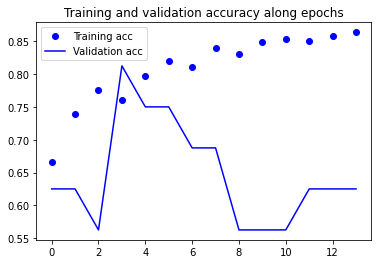

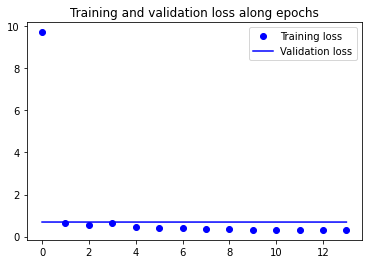

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy along epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss along epochs')
plt.legend()
plt.show()

In [0]:
val_loss, val_acc = model_3.evaluate_generator(validation_generator, 
                                               steps=50)

print('val loss:', val_loss)
print('val acc:', val_acc)

val loss: 0.691329300403595
val acc: 0.625


> Acurracy droped from the previous model.

__Plot Confusion Matrix__

In [0]:
# from sklearn.metrics import confusion_matrix
y_true=validation_generator.classes
print(y_true)

y_pred = model_3.predict_generator(validation_generator)
y_pred = np.rint(y_pred)
print(y_pred)

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM , 
                                figsize=(7, 7), 
                                hide_ticks=True, 
                                cmap=plt.cm.Blues)
# plt.xticks(range(len(classes)), classes, fontsize=12)
# plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix for ...: \n") #+model_title, fontsize=11
# fig.savefig(image_file_name_CM, dpi=100)
plt.show()

NameError: ignored

In [0]:
# download the model
files.download('./models/p3_model_3.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 36166, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

### Evaluate Model 3 on Test Data

In [0]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model_3.evaluate_generator(test_generator, steps=50)

print('test loss:', test_loss)
print('test acc:', test_acc)

Found 624 images belonging to 2 classes.
test loss: 0.688644528388977
test acc: 0.6707317233085632


>The accuracy score for test data is even (slightly) lower than that of the second model.